Import Libraries

In [1]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.layers import Conv2D,MaxPool2D
from keras import backend as k

Variables:
batch: the process of splitting the training dataset in n batches (mini-batches),
classes: number of classifications (labels) of the data,
epochs: variations, one epoch is one forward pass + one backward pass on training

In [2]:
#batch_size = 20
num_classes = 10
epochs = 4

a function that returns audio in numeric representation

In [3]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    #wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

Check a sample of audio

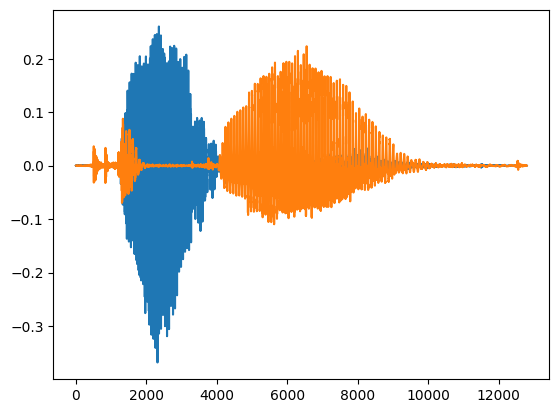

In [4]:
TRAIN_FILE = os.path.join('audio-data','Train','C03n_0.wav')
TEST_FILE = os.path.join('audio-data','Test','C04n_2.wav')
wave = load_wav_16k_mono(TRAIN_FILE)
nwave = load_wav_16k_mono(TEST_FILE)
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [5]:
TRAIN = os.path.join('audio-data', 'Train')
TEST = os.path.join('audio-data', 'Test')

Read all audio files and sort

In [6]:
train = tf.data.Dataset.list_files(TRAIN+'\*.wav')
train = sorted(list(train.as_numpy_iterator()))
train = tf.data.Dataset.from_tensor_slices(train)
test = tf.data.Dataset.list_files(TEST+'\*.wav')
test = sorted(list(test.as_numpy_iterator()))
test = tf.data.Dataset.from_tensor_slices(test)

Add Labels

In [24]:
iterations = 0
i = 0
train_label = []
while iterations!=len(train):
    iterations +=1
    train_label.append(i)
    i += 1
    if i == 10 :
        i = 0
train_label=keras.utils.to_categorical(train_label,num_classes)
trainings = tf.data.Dataset.zip((train, tf.data.Dataset.from_tensor_slices(train_label)))
#---------------------------------------------------------------#
iterations = 0
i = 0
test_label=[]
while iterations!=len(test):
    iterations +=1
    test_label.append(i)
    i += 1
    if i == 10 :
        i = 0
test_label=keras.utils.to_categorical(test_label,num_classes)
testings = tf.data.Dataset.zip((test, tf.data.Dataset.from_tensor_slices(test_label)))

Build Preprocessing Function to get spectogram

In [8]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    #wav = wav[:48000]
    #zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    #wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

Draw examples of spectogram

c:\Users\Ali\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


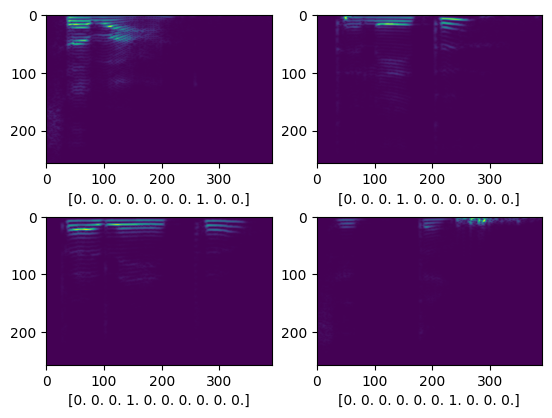

In [25]:
for i in range(4):
    filepath, label = trainings.shuffle(buffer_size=10000).as_numpy_iterator().next()
    spectrogram, label = preprocess(filepath, label)
    plt.subplot(2,2,i+1)
    plt.imshow(tf.transpose(spectrogram)[0])
    plt.xlabel(label)
plt.show()

Convert all to Spectogram

In [26]:
# train data
x_train = trainings.map(preprocess)
x_train = x_train.cache()
x_train = x_train.shuffle(buffer_size=1000)
x_train = x_train.batch(16) # 16 at a time
x_train = x_train.prefetch(8)
# test data
x_test = testings.map(preprocess)
x_test = x_test.cache()
x_test = x_test.shuffle(buffer_size=1000)
x_test = x_test.batch(16) # 16 at a time
x_test = x_test.prefetch(8)

In [27]:
# test one batch
samples, labels = x_train.as_numpy_iterator().next()
print(samples.shape)
print('\n',labels)

(16, 391, 257, 1)

 [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


Design the CNN architecture

In [12]:
model=Sequential()
input_shape = (391, 257, 1)
model.add( Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape) )
model.add( MaxPool2D(pool_size=(2,2)) )
model.add( Conv2D(64,kernel_size=(3,3),activation='relu') )
model.add( MaxPool2D(pool_size=(2,2)) )
model.add( Conv2D(64,kernel_size=(3,3),activation='relu') )
model.add( Flatten() )
model.add( Dense(32,activation='relu') )
model.add( Dense(num_classes,activation='softmax') )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 389, 255, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 194, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 96, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 94, 60, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 360960)            0

Compile the model

In [28]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy']
             )

In [29]:
model.fit(x_train,
          epochs=epochs,
          validation_data=x_test
          )

Epoch 1/4
75/75 [==============================] - 160s 2s/step - loss: 1.1069 - accuracy: 0.6783 - val_loss: 1.4680 - val_accuracy: 0.7400
Epoch 2/4
75/75 [==============================] - 140s 2s/step - loss: 0.3285 - accuracy: 0.9267 - val_loss: 0.7541 - val_accuracy: 0.8033
Epoch 3/4
75/75 [==============================] - 136s 2s/step - loss: 0.1541 - accuracy: 0.9575 - val_loss: 1.7895 - val_accuracy: 0.7967
Epoch 4/4
75/75 [==============================] - 138s 2s/step - loss: 0.1621 - accuracy: 0.9683 - val_loss: 1.8211 - val_accuracy: 0.8033


Save the Model

In [30]:
model.save('simpleCNNmodel_audio.h5')
print("model is saved")

model is saved
